In [1]:
import numpy as np
import netCDF4 as nc
from Tools import panfxns as pf
import matplotlib.pyplot as plt
import cmocean
%matplotlib inline

hostname: ldt-4728172.gfdl.noaa.gov


In [2]:
#to do: check sign on everything and figure out where factor of -1 went wrong

In [3]:
ufile='/work/ebo/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.196001-196412.umo.nc'
vfile='/work/ebo/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly_z/ts/monthly/5yr/ocean_monthly_z.196001-196412.vmo.nc'

In [4]:
def calc_deta_dt_term1(thk, wcdep, detadt):#, w_est0):
    
    #reshape:
    thk = np.expand_dims(thk, axis=0).filled(0.)
    wcdep = np.expand_dims(wcdep, axis=(0,1)).filled(np.nan)
    detadt = np.expand_dims(detadt, axis=1).filled(0.)
    
    adj = thk/wcdep*detadt
    
    __, nk, nlat, nlon = thk.shape
    ntime = np.shape(detadt)[0]
    w_adj = np.ma.zeros( (ntime, nk+1, nlat, nlon)  )
    w_adj[:,-1,:,:] = 0.
    # Do a double-flip so that we integrate from the bottom
    w_adj[:,:-1,:,:] = adj[:,-1::-1,:,:].cumsum(axis=1)[:,::-1,:,:]
    
    #w=w_adj+w_est0
    
    return w_adj

In [5]:
def calc_deta_dt_term2(thk, detadt):#, w_est0):
    
    #reshape:
    wcdep=np.sum(thk,axis=0)
    thk = np.expand_dims(thk, axis=0).filled(0.)
    wcdep = np.expand_dims(wcdep, axis=(0,1)).filled(np.nan)
    detadt = np.expand_dims(detadt, axis=1).filled(0.)
    
    adj = thk/wcdep*detadt
    
    __, nk, nlat, nlon = thk.shape
    ntime = np.shape(detadt)[0]
    w_adj = np.ma.zeros( (ntime, nk+1, nlat, nlon)  )
    w_adj[:,-1,:,:] = 0.
    # Do a double-flip so that we integrate from the bottom
    w_adj[:,:-1,:,:] = adj[:,-1::-1,:,:].cumsum(axis=1)[:,::-1,:,:]
    
    #w=w_adj+w_est0
    
    return w_adj

In [6]:
def calc_w_from_convergence(u_var, v_var, wrapx = True, wrapy = False):

    tmax = u_var.shape[0]

    ntime, nk, nlat, nlon = u_var.shape
    w = np.ma.zeros( (ntime, nk+1, nlat, nlon)  )
    # Work timelevel by timelevel
    #note: if u gives u_i's, roll(u,1) gives u[(i-1)'s']
    for tidx in range(0,tmax):
        # Get and process the u component
        u_dat = u_var[tidx,:,:,:]
        h_mask = np.logical_or(np.ma.getmask(u_dat), np.ma.getmask(np.roll(u_dat,1,axis=-1)))
        u_dat = u_dat.filled(0.)

        # Get and process the v component
        v_dat = v_var[tidx,:,:,:]
        h_mask = np.logical_or(h_mask,np.ma.getmask(v_dat))
        h_mask = np.logical_or(h_mask,np.ma.getmask(np.roll(v_dat,1,axis=-2)))
        v_dat = v_dat.filled(0.)

        # Order of subtraction based on upwind sign convention and desire for w>0 to correspond with upwards velocity
        w[tidx,:-1,:,:] += np.roll(u_dat,1,axis=-1)-u_dat # u_(i-1)-u(i)
        if not wrapx: # If not wrapping, then convergence on westernmost side is simply so subtract back the rolled value
            w[tidx,:-1,:,0] += -u_dat[:-1,:,-1]
        w[tidx,:-1,:,:] += np.roll(v_dat,1,axis=-2)-v_dat
        if not wrapy: # If not wrapping, convergence on westernmost side is v
            w[tidx,:-1,0,:] += -v_dat[:,-1,:]
        w[tidx,-1,:,:] = 0.
        # Do a double-flip so that we integrate from the bottom
        w[tidx,:-1,:,:] = w[tidx,-2::-1,:,:].cumsum(axis=0)[::-1,:,:]
        # Mask if any of u[i-1], u[i], v[j-1], v[j] are not masked
        w[tidx,:-1,:,:] = np.ma.masked_where(h_mask, w[tidx,:-1,:,:])
        # Bottom should always be zero, mask applied wherever the top interface is a valid value
        w[tidx,-1,:,:] = np.ma.masked_where(h_mask[-2,:,:], w[tidx,-1,:,:])

    return w

In [8]:
static='/work/ebo/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly_z/ocean_monthly_z.static.nc'
fstat=nc.Dataset(static)
thk=fstat.variables['thkcello'][:,:,:]
wcdep=fstat.variables['deptho'][:,:]
area = fstat.variables['areacello'][:,:]
ec='/work/ebo/archive/Elise.Olson/fre/xanadu_esm4_20190304/ESM4/202205/ESM4_historical_D1_WMO_1961/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_monthly/ts/monthly/1yr/ocean_monthly.196101-196112.deta_dt.nc'
with nc.Dataset(ec) as fec:
    detadt=fec.variables['deta_dt'][:,:,:]
with nc.Dataset(ufile) as fu:
    print(fu.variables['umo'])
    u_var = fu.variables['umo'][12:24,:,:,:]
with nc.Dataset(vfile) as fv:
    v_var = fv.variables['vmo'][12:24,:,:,:]
#alpha=1.0e-2
#detadt=alpha*np.ones([3,np.shape(thk)[1],np.shape(thk)[2]])

/tmp/ipykernel_17922/4185857693.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  thk=fstat.variables['thkcello'][:,:,:]


<class 'netCDF4._netCDF4.Variable'>
float32 umo(time, z_l, yh, xq)
    long_name: Ocean Mass X Transport
    units: kg s-1
    missing_value: 1e+20
    _FillValue: 1e+20
    cell_methods: z_l:sum yh:sum xq:point time: mean
    time_avg_info: average_T1,average_T2,average_DT
    standard_name: ocean_mass_x_transport
    interp_method: none
unlimited dimensions: time
current shape = (60, 35, 576, 720)
filling on


In [9]:
wadj1=calc_deta_dt_term1(thk, wcdep, detadt)

In [10]:
wadj2=calc_deta_dt_term2(thk, detadt)

In [11]:
np.nanmax(np.abs(wadj1-wadj2))

1.1368683772161603e-13

In [31]:
# check that wadj(0) is deta_dt:
np.nanmax(np.abs((wadj1[0,0,:,:]-detadt[0,:,:]))),np.nanmax(np.abs((wadj2[0,0,:,:]-detadt[0,:,:])))

(7.105427357601002e-14, 5.684341886080802e-14)

In [12]:
w0=calc_w_from_convergence(u_var, v_var, wrapx = True, wrapy = False)

In [13]:
wdiv = w0/(np.expand_dims(area,(0,1))*1035.0)

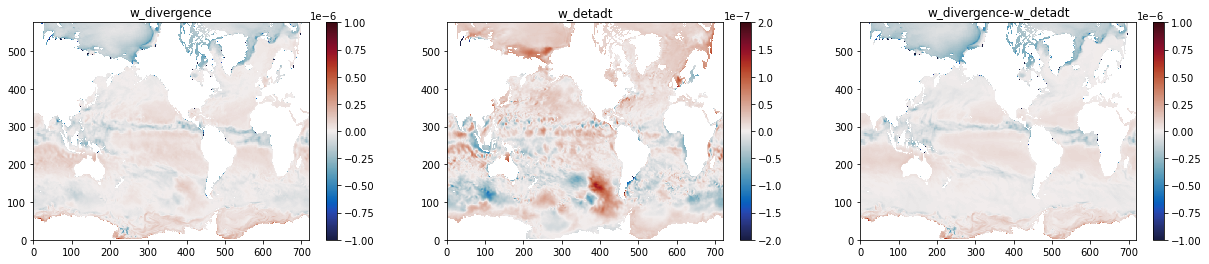

In [14]:
cmap=cmocean.cm.balance
fig,ax=plt.subplots(1,3,figsize=(21,4))
m0=ax[0].pcolormesh(wdiv[5,0,:,:],vmin=-1e-6,vmax=1e-6,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(wadj1[5,0,:,:],vmin=-2e-7,vmax=2e-7,cmap=cmap)
fig.colorbar(m1,ax=ax[1])
m2=ax[2].pcolormesh(wdiv[5,0,:,:]-wadj1[5,0,:,:],vmin=-1e-6,vmax=1e-6,cmap=cmap)
fig.colorbar(m2,ax=ax[2])
ax[0].set_title('w_divergence')
ax[1].set_title('w_detadt')
ax[2].set_title('w_divergence-w_detadt');

### First, look at meridional equatorial section near 140 N, to ~500m depth, full-year (1961) average, zonal mean over ~20° of longitude

In [15]:
# look at equatorial transect
fstat.variables.keys()
ii=np.argmin(np.abs(fstat.variables['geolon'][int(576/2),:]-(-140)))
jjs=np.argmin(np.abs(fstat.variables['geolat'][:,ii]-(-15)))
jje=np.argmin(np.abs(fstat.variables['geolat'][:,ii]-  15 ))+1
kk=np.argmin(np.abs(fstat.variables['z_i'][:]-500))+2
zzs=fstat.variables['z_i'][:kk]
lats=fstat.variables['geolat'][jjs:jje,ii]

In [16]:
wdiv_seg=np.mean(np.mean(wdiv[:,:kk,jjs:jje,(ii-20):(ii+20+1)],-1),0)

In [17]:
wadj_seg=np.mean(np.mean(wadj1[:,:kk,jjs:jje,(ii-20):(ii+20+1)],-1),0)

In [18]:
wadj_seg2=np.mean(np.mean(wadj2[:,:kk,jjs:jje,(ii-20):(ii+20+1)],-1),0)

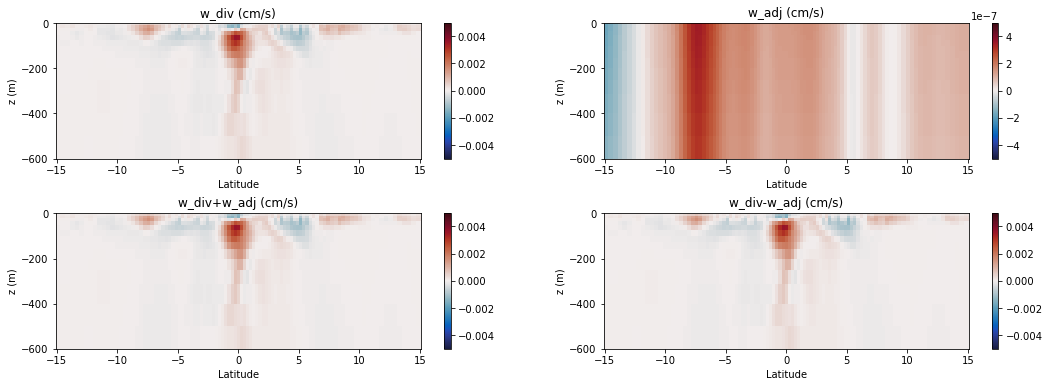

In [19]:
fig,ax=plt.subplots(2,2,figsize=(18,6))
fig.subplots_adjust(hspace=.4)
ax=ax.flatten()
m0=ax[0].pcolormesh(lats,-1*zzs,wdiv_seg*100,shading='nearest',vmin=-5e-3,vmax=5e-3,cmap=cmap)
fig.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(lats,-1*zzs,wadj_seg*100,shading='nearest',vmin=-5e-7,vmax=5e-7,cmap=cmap)
fig.colorbar(m1,ax=ax[1])
m2=ax[2].pcolormesh(lats,-1*zzs,(wadj_seg+wdiv_seg)*100,shading='nearest',vmin=-5e-3,vmax=5e-3,cmap=cmap)
fig.colorbar(m2,ax=ax[2])
m3=ax[3].pcolormesh(lats,-1*zzs,(wdiv_seg-wadj_seg)*100,shading='nearest',vmin=-5e-3,vmax=5e-3,cmap=cmap)
fig.colorbar(m3,ax=ax[3])
ax[0].set_title('w_div (cm/s)')
ax[1].set_title('w_adj (cm/s)')
ax[2].set_title('w_div+w_adj (cm/s)')
ax[3].set_title('w_div-w_adj (cm/s)')
for iax in ax:
    iax.set_xlabel('Latitude')
    iax.set_ylabel('z (m)')

Text(0, 0.5, 'z (m)')

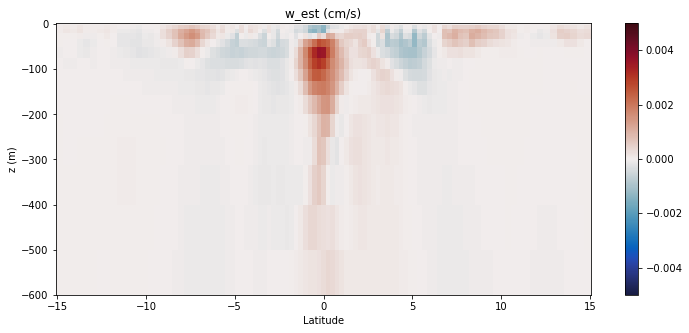

In [23]:
fig,ax=plt.subplots(1,1,figsize=(12,5))
m0=ax.pcolormesh(lats,-1*zzs,(wdiv_seg+wadj_seg)*100,shading='nearest',vmin=-5e-3,vmax=5e-3,cmap=cmap)
fig.colorbar(m0,ax=ax)
ax.set_title('w_est (cm/s)')
ax.set_xlabel('Latitude')
ax.set_ylabel('z (m)')

### Next check whether surface (eta+D)/D*w*, or w_div+w_adj, satisfies bc,    (eta+D)/D* w* =-(P-E+R)

WFO=WATER FLUX INTO SEAWATER, p-e+r+frazile etc

check w_div+w_adj=-WFO; WFO+w_div+w_adj=0

In [32]:
wfofile='/work/Elise.Olson/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_historical_D1/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.196001-196412.wfo.nc'
with nc.Dataset(wfofile) as fwfo:
    print(fwfo.variables['wfo'].long_name)
    print(fwfo.variables['wfo'].standard_name)
    print(fwfo.variables['wfo'].units)
    wfo=fwfo.variables['wfo'][12:24,:,:]/1035 # convert to m/s

Water Flux Into Sea Water
water_flux_into_sea_water
kg m-2 s-1


Text(0.5, 1.0, 'July wfo at surface (m/s)')

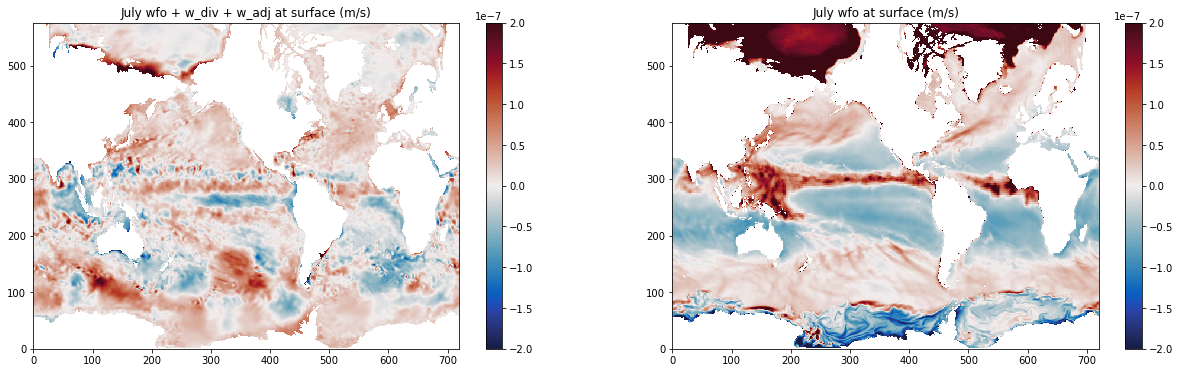

In [34]:
cmap=cmocean.cm.balance
ll=6 # July
fig,ax=plt.subplots(1,2,figsize=(21,6))
m0=ax[0].pcolormesh(wfo[ll,:,:]+wadj2[ll,0,:,:]+wdiv[ll,0,:,:],vmin=-2e-7,vmax=2e-7,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m0,ax=ax[0])
m2=ax[1].pcolormesh(wfo[ll,:,:],vmin=-2e-7,vmax=2e-7,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m2,ax=ax[1])
ax[0].set_title('July wfo + w_div + w_adj at surface (m/s)')
ax[1].set_title('July wfo at surface (m/s)')

Text(0.5, 1.0, 'July wfo at surface (m/s)')

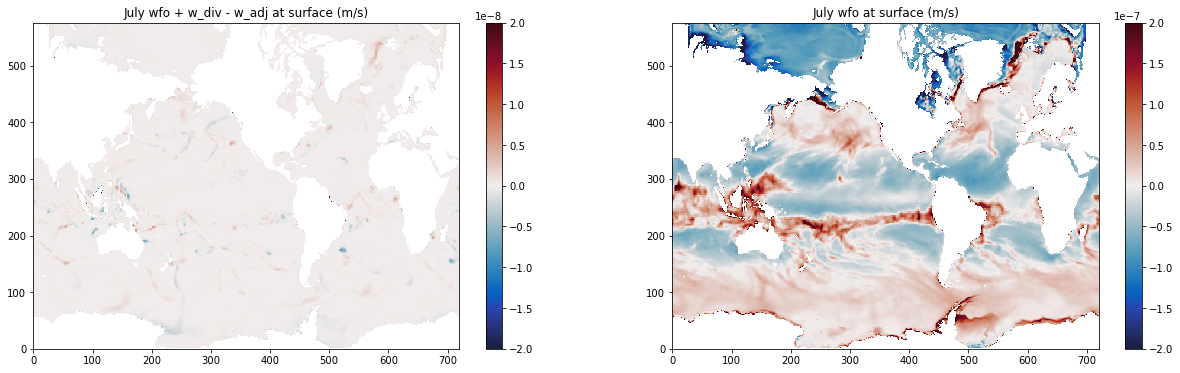

In [41]:
cmap=cmocean.cm.balance
fig,ax=plt.subplots(1,2,figsize=(21,6))
m0=ax[0].pcolormesh(wfo[ll,:,:]-wadj2[ll,0,:,:]+wdiv[ll,0,:,:],vmin=-2e-8,vmax=2e-8,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m0,ax=ax[0])
m2=ax[1].pcolormesh(wfo[ll,:,:],vmin=-2e-7,vmax=2e-7,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m2,ax=ax[1])
ax[0].set_title('July wfo + w_div - w_adj at surface (m/s)')
ax[1].set_title('July wfo at surface (m/s)')

Text(0.5, 1.0, 'Feb wfo at surface (m/s)')

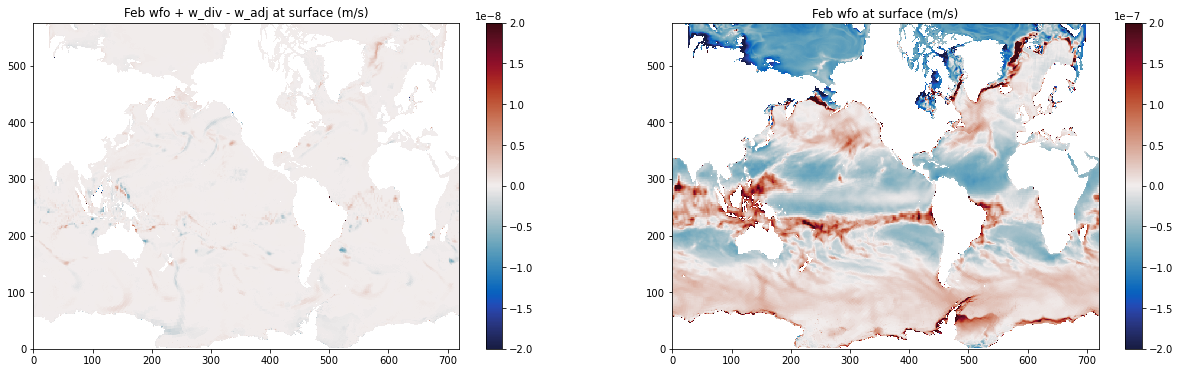

In [40]:
cmap=cmocean.cm.balance
ll=1; # Feb
fig,ax=plt.subplots(1,2,figsize=(21,6))
m0=ax[0].pcolormesh(wfo[ll,:,:]-wadj2[ll,0,:,:]+wdiv[ll,0,:,:],vmin=-2e-8,vmax=2e-8,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m0,ax=ax[0])
m2=ax[1].pcolormesh(wfo[ll,:,:],vmin=-2e-7,vmax=2e-7,cmap=cmap)#vmin=v1,vmax=v2,
fig.colorbar(m2,ax=ax[1])
ax[0].set_title('Feb wfo + w_div - w_adj at surface (m/s)')
ax[1].set_title('Feb wfo at surface (m/s)')

### Question: Is wfo + wdiv - wadj = 0 correct? Does w*=wdiv-wadj everywhere?
This makes sense intuitively if wdiv is the component based on divergence with the grid configured as at t=t0, and the wadj is the movement of the grid over the time step, t0 to t0+dt. Then if w* is the motion of water across the z* interface, it would be approximately wdiv-wadj (if the velocity due to divergence is upwards, and the motion of the interface is downwards, the motion across the interface is increased). 

However, I cannot reconcile this with the equations in Diagnosing_w.pdf. Probably I am misunderstanding the sign of one of the terms.